In [1]:
%matplotlib inline

In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np

default_dir = os.path.dirname(os.getcwd())
os.chdir(default_dir)

import RLConn as rc

W0413 09:36:45.126287 4533956032 deprecation_wrapper.py:119] From /Users/Frank/github/RLConn/RLConn/control_dqn.py:5: The name tf.set_random_seed is deprecated. Please use tf.compat.v1.set_random_seed instead.

W0413 09:36:45.261523 4533956032 deprecation_wrapper.py:119] From /Users/Frank/github/RLConn/RLConn/control_dqn.py:58: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0413 09:36:45.277795 4533956032 deprecation_wrapper.py:119] From /Users/Frank/github/RLConn/RLConn/control_dqn.py:66: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

W0413 09:36:45.282114 4533956032 deprecation.py:323] From /Users/Frank/github/RLConn/RLConn/control_dqn.py:68: dense (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.dense instead.
W0413 09:36:46.178004 4533956032 deprecation_wrapper.py:119] From /Users/Frank/github/RLConn/RLConn/control

In [3]:
from contextlib import contextmanager
import sys, os

@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:  
            yield
        finally:
            sys.stdout = old_stdout

In [4]:
def get_observe(Gg, Gs):
    N = Gg.shape[0]
    return np.concatenate((Gg[np.triu_indices(N,k=1)],Gs[np.triu_indices(N,k=1)],Gs[np.tril_indices(N,k=-1)]))

In [5]:
def move(Gg, Gs, action, location, dx = 0.1):
    N = Gg.shape[0]
    size = int(N*(N-1)/2)
    change = dx*(action == 0) + (-dx)*(action == 2)
    if location < size:
        coordinate = np.array(np.triu_indices(N,k=1)).T[location]
        Gg[coordinate[0], coordinate[1]] += change
        Gg[coordinate[1], coordinate[0]] += change
    elif location < 2*size:
        coordinate = np.array(np.triu_indices(N,k=1)).T[location - size]
        Gs[coordinate[0], coordinate[1]] += change
    else: 
        coordinate = np.array(np.tril_indices(N,k=-1)).T[location - 2*size]
        Gs[coordinate[0], coordinate[1]] += change
    return Gg, Gs

In [6]:
def get_rand_action(N):
    size = int(N*(N-1)/2)
    return np.random.randint(2), np.random.randint(3*size)

In [7]:
def get_reward(Gg, Gs):
    with suppress_stdout():
        mean_err,_ = rc.utils.compute_score(Gg, Gs, E, 
                                            input_vec, ablation_mask, 
                                            tf = tf, t_delta = 0.01, cutoff_1=cutoff_1, cutoff_2=cutoff_2,
                                            plot_result = False,
                                            verbose = False)
    np.random.seed() #reset seed
    return -mean_err

In [8]:
def update_x(x, Gg, Gs, reward):
    obs = get_observe(Gg, Gs)
    x = np.concatenate((x[len(obs)+1:], obs))
    x = np.append(x,reward)
    return x

In [9]:
# initialize
N = 3
size = int(3*N*(N-1)/2)
PG = rc.alpg.ActLocPolicyGradient(
    n_actions=3,
    n_features=(size+1)*10)

E = np.array([[0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.]])
ablation_mask = np.ones(N)

# change
input_vec = np.zeros(N)
input_vec[1] = 0.25

tf = 10
cutoff_1 = 400
cutoff_2 = 900

In [10]:
import warnings
warnings.filterwarnings("error")

episode: 0   reward: -66266
Gg: [ 0 31 11 31  0 16 11 16  0]   Gs: [ 0 17 14  7  0  4 23 36  0]


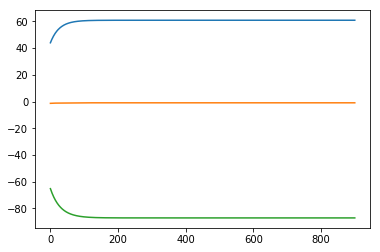

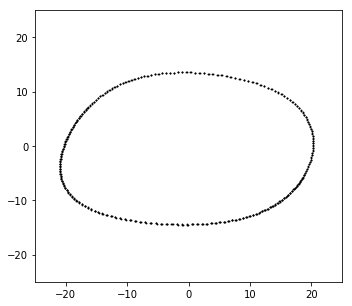

105.40428699419718
episode: 1   reward: -65980
Gg: [ 0  8 11  8  0 24 11 24  0]   Gs: [ 0 10 11  3  0 -6  7 45  0]


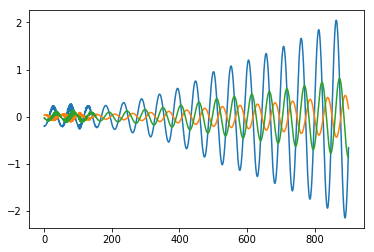

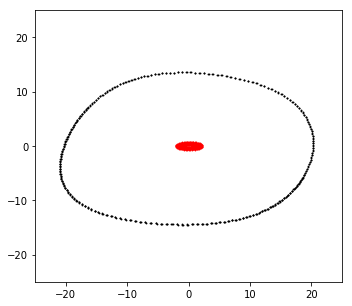

17.92901285955496
episode: 2   reward: -65979
Gg: [ 0 31 15 31  0 10 15 10  0]   Gs: [ 0 19 21 12  0  8 21 26  0]


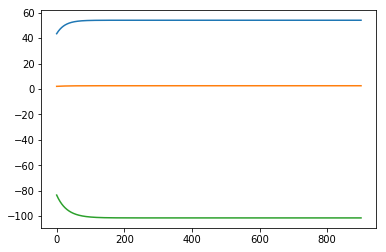

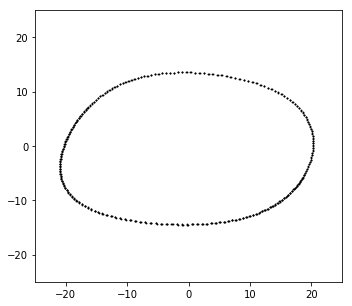

114.09754886329043
episode: 3   reward: -66026
Gg: [ 0 31  9 31  0 19  9 19  0]   Gs: [ 0 20 19 11  0  7 28 36  0]


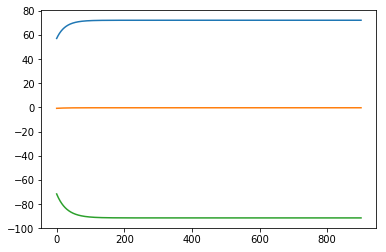

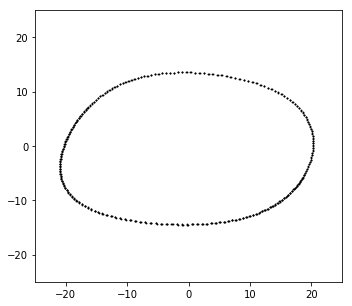

115.62448622963329
episode: 4   reward: -66004
Gg: [ 0 37 11 37  0 28 11 28  0]   Gs: [ 0 22 20 11  0  2 27 28  0]


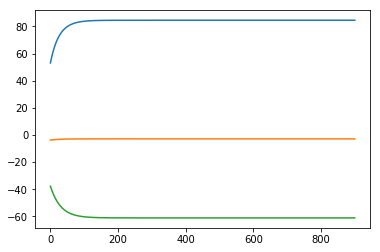

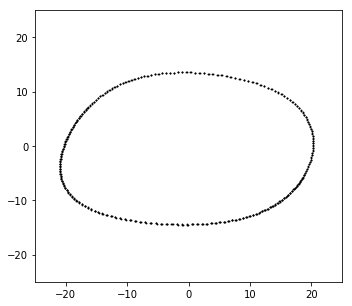

103.59496726524787
episode: 5   reward: -66138
Gg: [ 0 33  8 33  0 43  8 43  0]   Gs: [ 0 23 11 18  0  4 32 16  0]


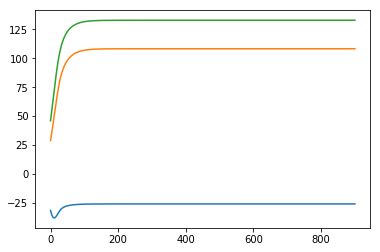

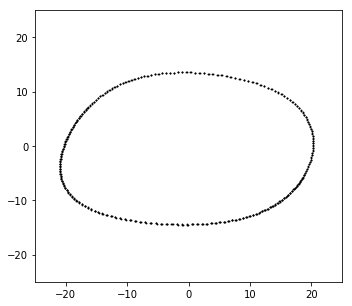

174.93594274584024


In [ ]:
nsteps = 400

for i_episode in range(300):
    #initialize x
    x = np.array([])
    network = rc.network_sim.generate_random_network(N, 1, 10)
    Gg, Gs = network['gap'], network['syn']
    reward = get_reward(Gg, Gs)
    x = np.concatenate((x, get_observe(Gg, Gs)))
    x = np.append(x,reward)
    for i in range(9):
        action, location = get_rand_action(N)
        Gg, Gs = move(Gg, Gs, action, location, dx=1)
        reward = get_reward(Gg, Gs)
        x = np.concatenate((x, get_observe(Gg, Gs)))
        x = np.append(x,reward)   
        
    #choose action using nn
    for step in range(nsteps):
        action, location = PG.choose_action(x)
        Gg, Gs = move(Gg, Gs, action, location, dx=1)
        try:
            reward = get_reward(Gg, Gs)
            if step == nsteps-1:
                reward = -1e4 if reward < -19 else reward*100
            PG.store_transition(x, action, location, reward)
            x = update_x(x, Gg, Gs, reward)
        except Warning:
            reward = -1e4
            PG.store_transition(x, action, location, reward)
            x = update_x(x, Gg, Gs, reward)
            print("Terminated early due to invalid Gg, Gs.")
            break
        
    ep_rs_sum = sum(PG.ep_rs)
    if 'running_reward' not in globals():
        running_reward = ep_rs_sum
    else:
        running_reward = running_reward * 0.99 + ep_rs_sum * 0.01
    print("episode:", i_episode, "  reward:", int(running_reward))
    print("Gg:", Gg.flatten(), "  Gs:", Gs.flatten())
    
    try:
        with suppress_stdout():
            mean_error, _ = rc.utils.compute_score(Gg, Gs, network['directionality'], 
                                                input_vec, ablation_mask,
                                                  tf = tf, t_delta = 0.01,
                                                  cutoff_1 = cutoff_1, cutoff_2 = cutoff_2,
                                                  plot_result = True)
        print(mean_error)
    except Warning:
        pass
        
    vt = PG.learn()
    # print(vt)